In [1]:
cd ..

/home/martinsevilla/topology_langevin


### Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch
import pickle as pkl
import networkx as nx

from topology_inference import estimators_white_noise as est
from topology_inference import initial_estimators as init
import topology_inference.utils as ut

# np.set_printoptions(suppress=True)

plt.rcParams['figure.figsize'] = [6, 5]

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=11)    # legend fontsize

mpl.rcParams['font.family'] = 'serif'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

torch.set_default_device("cuda")
torch.set_default_dtype(torch.float64)

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

### Data creation

In [3]:
seed = 120
torch.manual_seed(seed)
np.random.seed(seed)
graph_type = "deezer_ego"

model_files = {
    "deezer_ego": ("edp_gnn/exp/deezer_ego/edp-gnn_train_deezer_ego__Jun-14-14-14-11_1489048/models/" +
                   "train_deezer_ego_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth"),
    "barabasi": ("edp_gnn/exp/barabasi_albert_diff_nodes/edp-gnn_barabasi_albert_[47, 49, 51, 53]__Jun-13-10-13-20_999031/models/" + 
                 "barabasi_albert_[47, 49, 51, 53]_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth"),
    "barabasi_smaller": ("edp_gnn/exp/barabasi_albert_diff_nodes_small/edp-gnn_barabasi_albert_[15, 17, 19, 21, 23]__Aug-07-15-50-45_2986529/models/" + 
                         "barabasi_albert_[15, 17, 19, 21, 23]_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth"),
    "grids": ("edp_gnn/exp/grids_dif_nodes/edp-gnn_grids_dif_nodes__Feb-12-22-48-21_4158697/models/" +
              "grids_dif_nodes_[0.03, 0.08222222, 0.13444444, 0.18666667, 0.23888889, 0.29111111, 0.34333333, 0.39555556, 0.44777778, 0.5].pth")
}

if graph_type == "deezer_ego":
    with open("edp_gnn/data/test_deezer_ego.pkl", "rb") as f:
        graphs = pkl.load(f)
        g = graphs[np.random.randint(len(graphs))]
        A = nx.to_numpy_array(g, nodelist=np.random.permutation(g.nodes()))
        A = torch.tensor(A)
    max_nodes = 25
elif graph_type == "barabasi":
    g = nx.dual_barabasi_albert_graph(50, 2, 4, 0.5, seed=seed)
    max_nodes = 53
elif graph_type == "barabasi_smaller":
    g = nx.dual_barabasi_albert_graph(20, 2, 4, 0.5, seed=seed)
    max_nodes = 23
elif graph_type == "grids":
    m_min = 5
    m_max = 9
    min_nodes = 40
    max_nodes = 49
    min_random_edges = 2
    max_random_edges = 5
    seed = 0
    g = ut.generate_grid_graph(m_min, m_max, min_nodes, max_nodes, min_random_edges, max_random_edges)
    max_nodes = 49

# A = torch.randint(0, 2, (5, 5)).double()
# A = torch.triu(A) + torch.triu(A, 1).T
# A.fill_diagonal_(0.0)
model_file = model_files[graph_type]
A = nx.to_numpy_array(g, nodelist=np.random.permutation(g.nodes()))
A = torch.tensor(A)
# Number of nodes
n = A.shape[0]
# Number of measurements
k = 50
# Filter parameters
theta_min, theta_max = -0.1, 0.1
n_theta = 3
h_theta = ut.poly_second_order
# Variance of the noise
# sigma_e = 1
# Unknown fraction of the matrix
p_unknown = 1.0

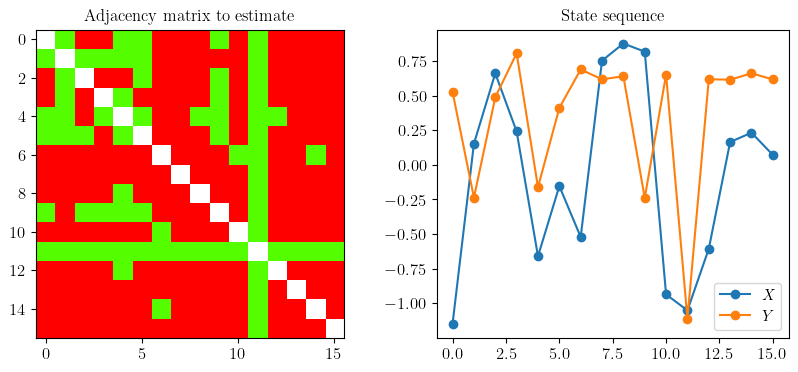

tensor([-0.0847,  0.0286, -0.0171], device='cuda:0')


In [4]:
# Dynamics matrix
theta_dist = torch.distributions.Uniform(theta_min, theta_max)
theta = theta_dist.sample([n_theta])
F = h_theta(A, *theta)

# L = ut.compute_laplacian(A)

# Generate white noise of unit variance
X = torch.randn(n, k)
Y = F @ X

# Generate unknown adjacency matrix
A_nan = ut.create_partially_known_graph(A, p_unknown)
known_idxs = torch.where(~ torch.isnan(A_nan))
unknown_idxs = torch.where(torch.isnan(A_nan))

A_plot = A.clone()
A_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_plot[known_idxs[1], known_idxs[0]] = torch.nan

# Plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('Adjacency matrix to estimate')
ax[1].plot(X.T.cpu()[np.random.randint(n)], "-o", label=r"$X$")
ax[1].plot(Y.T.cpu()[np.random.randint(n)], "-o", label=r"$Y$")
ax[1].set_title('State sequence')
ax[1].legend()
plt.show()
print(theta)

### Langevin estimator with Adam initializer

In [5]:
sigmas = torch.linspace(0.5, 0.03, 10)
epsilon = 1.0E-6
temperature = 0.5
lr = 0.01
steps = 300

lr_init = 0.01
n_epochs_init = 1000
n_samples_init = 5
margin = 0.3

model = ut.load_model(model_file)
A_score_model = ut.score_edp_wrapper(model, A.shape[0], len(sigmas), max_nodes=max_nodes)
# A_score_model = lambda A, _: torch.zeros(A.shape)

adam_init = init.AdamInitializer(h_theta=h_theta, theta_dist=theta_dist, lr=lr_init, n_epochs=n_epochs_init)

langevin_est = est.LangevinEstimator(h_theta=h_theta,
                                      A_score_model=A_score_model,
                                      theta_prior_dist=theta_dist)

In [6]:
A_init_adam, theta_init = adam_init.initial_estimation(Y=Y, l1_penalty=0.0, num_runs=n_samples_init, margin=margin)

In [7]:
A_lang_adam, theta_lang_adam = langevin_est.langevin_estimate(A_nan=A_init_adam, Y=Y, 
                                                              sigmas_sq=sigmas ** 2, epsilon=epsilon, 
                                                              temperature=temperature, steps=steps,
                                                              adam_lr=lr,
                                                              projection_method="copy", clip_A_tilde=True)

Real theta: tensor([-0.0847,  0.0286, -0.0171], device='cuda:0')
Estimated theta: tensor([-0.1402, -0.0460,  0.0821], device='cuda:0')
AUCROC: 0.8091655266757867
F1: 0.6176470588235294
Rel. error: 2.721087583350022
Normalized MSE: 2.2287883300869447


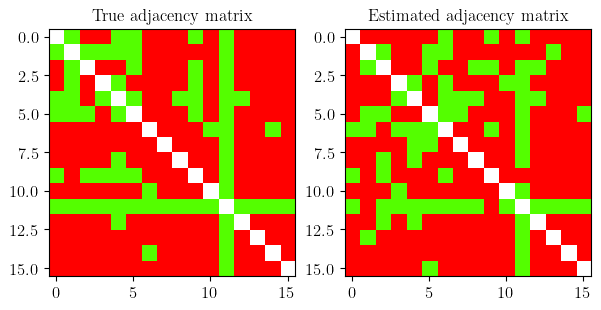

In [8]:
roc, threshold = ut.compute_aucroc(A, A_lang_adam, use_idxs=unknown_idxs, return_threshold=True)
A_est_plot = (A_lang_adam > 0.5).float().clone()
A_est_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_est_plot[known_idxs[1], known_idxs[0]] = torch.nan

print("Real theta:", theta)
print("Estimated theta:", theta_lang_adam)
print("AUCROC:", roc)
print("F1:", ut.compute_f1(A, A_est_plot, use_idxs=unknown_idxs))
print("Rel. error:", ut.compute_relative_error(theta, theta_lang_adam).item())
print("Normalized MSE:", ut.compute_normalized_mse(theta, theta_lang_adam).item())

fig, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('True adjacency matrix')
ax[1].imshow(A_est_plot.cpu(), cmap="prism")
ax[1].set_title('Estimated adjacency matrix')
plt.show()

### Langevin estimator with bootstrap initializer

In [9]:
sigmas = torch.linspace(0.5, 0.03, 10)
epsilon = 1.0E-6
temperature = 0.5
lr = 0.01
steps = 300

lr_init = 0.01
n_epochs_init = 1000
n_samples_init = 5
margin = 0.3

boot_init = init.BootstrapAdamInitializer(h_theta=h_theta, theta_dist=theta_dist, lr=lr_init, n_epochs=n_epochs_init)

In [10]:
A_init_boot, theta_init = boot_init.initial_estimation(Y=Y, l1_penalty=0.0, bootstrap_samples=n_samples_init, margin=margin)

In [11]:
A_lang_boot, theta_lang_boot = langevin_est.langevin_estimate(A_nan=A_init_boot, Y=Y, 
                                                              sigmas_sq=sigmas ** 2, epsilon=epsilon, 
                                                              temperature=temperature, steps=steps,
                                                              adam_lr=lr,
                                                              projection_method="copy", clip_A_tilde=True)

Real theta: tensor([-0.0847,  0.0286, -0.0171], device='cuda:0')
Estimated theta: tensor([0.1370, 0.0157, 0.0640], device='cuda:0')
AUCROC: 0.7640218878248973
F1: 0.6181818181818182
Rel. error: 1.9252992489454084
Normalized MSE: 6.741619775488007


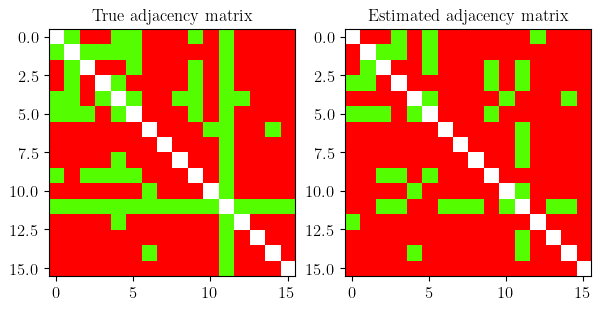

In [14]:
roc, threshold = ut.compute_aucroc(A, A_lang_boot, use_idxs=unknown_idxs, return_threshold=True)
A_est_plot = (A_lang_boot > 0.5).float().clone()
A_est_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_est_plot[known_idxs[1], known_idxs[0]] = torch.nan

print("Real theta:", theta)
print("Estimated theta:", theta_lang_boot)
print("AUCROC:", roc)
print("F1:", ut.compute_f1(A, A_est_plot, use_idxs=unknown_idxs))
print("Rel. error:", ut.compute_relative_error(theta, theta_lang_boot).item())
print("Normalized MSE:", ut.compute_normalized_mse(theta, theta_lang_boot).item())

fig, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('True adjacency matrix')
ax[1].imshow(A_est_plot.cpu(), cmap="prism")
ax[1].set_title('Estimated adjacency matrix')
plt.show()

### Adam estimator with Adam initializer

In [15]:
adam_est = est.AdamEstimator(h_theta=h_theta, lr=0.01, n_iter=1000, theta_prior_dist=theta_dist)

A_adam_adam, theta_adam_adam, loss_hist = adam_est.adam_estimate(A_nan=A_init_adam, Y=Y, l1_penalty=0.0)

Real theta: tensor([-0.0847,  0.0286, -0.0171], device='cuda:0')
Estimated theta: tensor([-0.0696, -0.0659,  0.1422], device='cuda:0')
AUCROC: 0.8471272229822162
F1: 0.0
Rel. error: 3.8480336328172884
Normalized MSE: 4.167066385793849


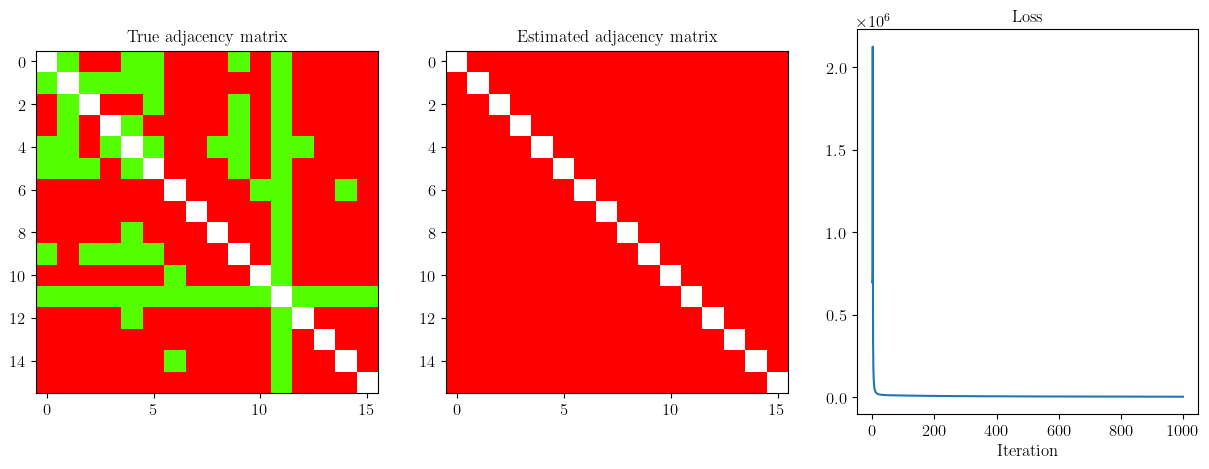

In [16]:
roc, threshold = ut.compute_aucroc(A, A_adam_adam, use_idxs=unknown_idxs, return_threshold=True)
A_est_plot = (A_adam_adam > 0.5).float().clone()
A_est_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_est_plot[known_idxs[1], known_idxs[0]] = torch.nan

print("Real theta:", theta)
print("Estimated theta:", theta_adam_adam)
print("AUCROC:", roc)
print("F1:", ut.compute_f1(A, A_adam_adam, use_idxs=unknown_idxs))
print("Rel. error:", ut.compute_relative_error(theta, theta_adam_adam).item())
print("Normalized MSE:", ut.compute_normalized_mse(theta, theta_adam_adam).item())
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('True adjacency matrix')

ax[1].imshow(A_est_plot.cpu(), cmap="prism")
ax[1].set_title('Estimated adjacency matrix')
 
ax[2].set_xlabel("Iteration")
ax[2].set_title("Loss")
ax[2].plot(loss_hist)
# ax[2].set_yscale('log')

plt.show()

### Adam estimator with bootstrap initializer

In [17]:
A_adam_boot, theta_adam_boot, loss_hist = adam_est.adam_estimate(A_nan=A_init_boot, Y=Y, l1_penalty=0.0)

Real theta: tensor([-0.0847,  0.0286, -0.0171], device='cuda:0')
Estimated theta: tensor([-0.0651, -0.0970,  0.3108], device='cuda:0')
AUCROC: 0.7404240766073871
F1: 0.5714285714285713
Rel. error: 7.481527489717102
Normalized MSE: 14.921925572003998


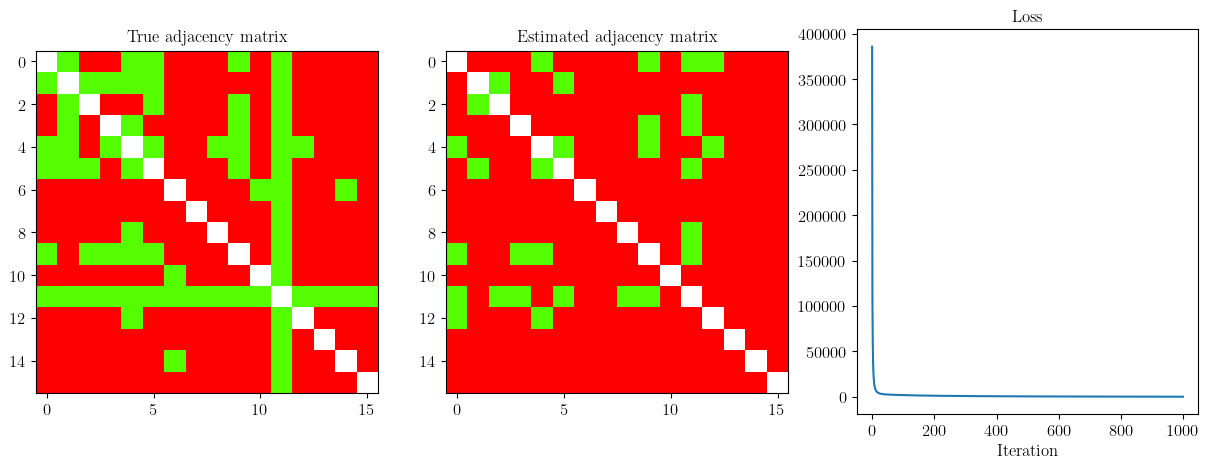

In [18]:
roc, threshold = ut.compute_aucroc(A, A_adam_boot, use_idxs=unknown_idxs, return_threshold=True)
A_est_plot = (A_adam_boot > 0.5).float().clone()
A_est_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_est_plot[known_idxs[1], known_idxs[0]] = torch.nan

print("Real theta:", theta)
print("Estimated theta:", theta_adam_boot)
print("AUCROC:", roc)
print("F1:", ut.compute_f1(A, A_adam_boot, use_idxs=unknown_idxs))
print("Rel. error:", ut.compute_relative_error(theta, theta_adam_boot).item())
print("Normalized MSE:", ut.compute_normalized_mse(theta, theta_adam_boot).item())
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('True adjacency matrix')

ax[1].imshow(A_est_plot.cpu(), cmap="prism")
ax[1].set_title('Estimated adjacency matrix')
 
ax[2].set_xlabel("Iteration")
ax[2].set_title("Loss")
ax[2].plot(loss_hist)
# ax[2].set_yscale('log')

plt.show()

### Spectral templates

In [19]:
spectral_est = est.SpectralTemplates()

In [25]:
emp_cov = (Y @ Y.T / k)
_, emp_cov_eigenvectors = torch.linalg.eigh(emp_cov)

In [45]:
S_espectral, _, _ = spectral_est.spectral_templates(emp_cov=emp_cov.cpu().numpy(),
                                                    emp_cov_eigenvectors=emp_cov_eigenvectors.cpu().numpy(),
                                                    epsilon_range=(0, 2))
S_espectral = torch.tensor(S_espectral)
S_espectral.fill_diagonal_(0.0)

	SpecTemp: 0th iteration took: 0.0101 s
	1th binary search iteration failed: infeasible
	SpecTemp: 2th iteration took: 0.0098 s
	SpecTemp: 3th iteration took: 0.0103 s
	SpecTemp: 4th iteration took: 0.0146 s
	Iter Refine: 0th iteration took: 0.0137 s
	Iter Refine: 1th iteration took: 0.0136 s
	Iter Refine: 2th iteration took: 0.0131 s


tensor([[ 0.0000e+00,  7.5963e-02,  7.5637e-02,  1.4931e-01,  1.1826e-01,
          2.0568e-01, -5.2535e-09,  5.1241e-02,  7.6051e-02,  7.4637e-02,
          1.0160e-01,  5.5151e-02,  1.4401e-02,  1.4567e-01,  8.9119e-04,
          4.6180e-02],
        [ 7.5963e-02,  0.0000e+00,  3.7689e-02,  7.1329e-02,  4.7982e-02,
          1.4884e-01, -5.0508e-09,  3.4553e-02, -5.1961e-09,  2.0590e-01,
          3.0958e-02,  1.9015e-01,  1.1452e-01,  5.3694e-02,  6.3958e-02,
          7.8150e-02],
        [ 7.5637e-02,  3.7689e-02,  0.0000e+00,  9.7225e-02, -5.1917e-09,
          2.3368e-01,  9.1953e-02,  4.5273e-02, -5.1600e-09,  5.2194e-02,
          7.5431e-02,  6.8764e-02,  4.6719e-02,  7.2233e-03,  1.2833e-01,
          3.9877e-02],
        [ 1.4931e-01,  7.1329e-02,  9.7225e-02,  0.0000e+00,  1.5757e-01,
          6.3906e-02, -5.3314e-09,  1.0342e-01,  7.1875e-02,  4.0772e-02,
         -5.1612e-09, -5.1114e-09,  1.0645e-01, -5.2153e-09,  1.0021e-01,
          1.1785e-01],
        [ 1.1826e-01

Real theta: tensor([-0.0847,  0.0286, -0.0171], device='cuda:0')
Estimated theta: tensor([-0.0651, -0.0970,  0.3108], device='cuda:0')
AUCROC: 0.6084131326949385
F1: 0.0
Rel. error: 7.481527489717102
Normalized MSE: 14.921925572003998


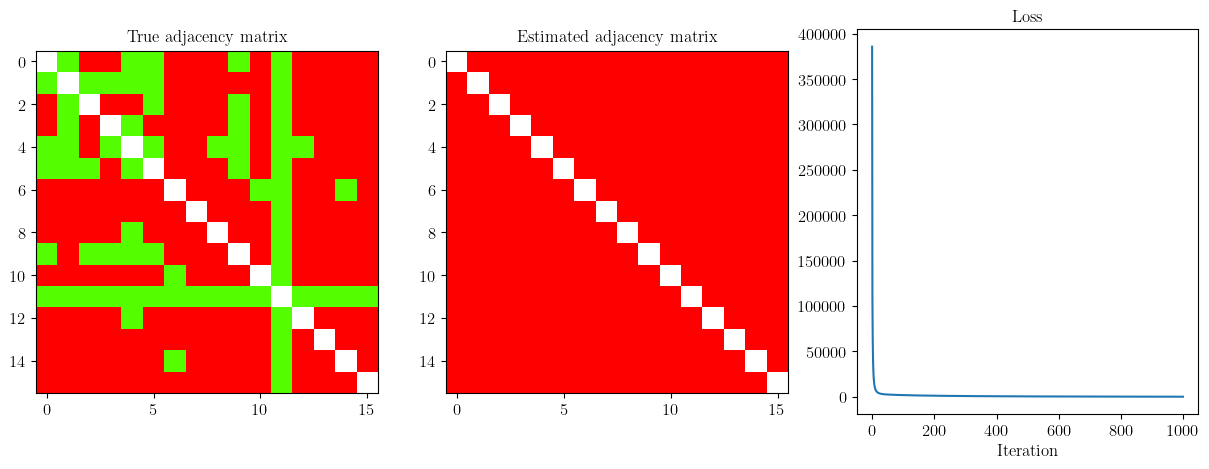

In [47]:
roc, threshold = ut.compute_aucroc(A, S_espectral, use_idxs=unknown_idxs, return_threshold=True)
A_est_plot = (S_espectral > 0.5).float().clone()
A_est_plot[known_idxs[0], known_idxs[1]] = torch.nan
A_est_plot[known_idxs[1], known_idxs[0]] = torch.nan

print("Real theta:", theta)
print("Estimated theta:", theta_adam_boot)
print("AUCROC:", roc)
print("F1:", ut.compute_f1(A, S_espectral, use_idxs=unknown_idxs))
print("Rel. error:", ut.compute_relative_error(theta, theta_adam_boot).item())
print("Normalized MSE:", ut.compute_normalized_mse(theta, theta_adam_boot).item())
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(A_plot.cpu(), cmap="prism")
ax[0].set_title('True adjacency matrix')

ax[1].imshow(A_est_plot.cpu(), cmap="prism")
ax[1].set_title('Estimated adjacency matrix')

# ax[2].set_yscale('log')

plt.show()